In [1]:
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio import features
from rasterio.features import rasterize
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_image
from functools import partial
from rasterio.enums import MergeAlg
import rasterio
from rasterio.transform import from_bounds
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import rioxarray
from shapely.geometry import box
from rasterio.features import shapes
from shapely.geometry import shape  # Ensure this is imported
import numpy as np

In [2]:
fiji = gpd.read_file("fiji.geojson").fillna(0).infer_objects().to_crs("EPSG:4326")
bbox = gpd.read_file("bbox_fiji.geojson").fillna(0).infer_objects().to_crs("EPSG:4326")
Yasa_64kn = gpd.read_file("swaths/Yasa_FJ_64kn.geojson").fillna(0).infer_objects().to_crs("EPSG:4326")

/tmp/ipykernel_1315/1364546420.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bbox = gpd.read_file("bbox_fiji.geojson").fillna(0).infer_objects().to_crs("EPSG:4326")


In [3]:
fiji = gpd.clip(fiji, bbox)
Yasa_64kn = gpd.clip(Yasa_64kn, bbox)

<Axes: >

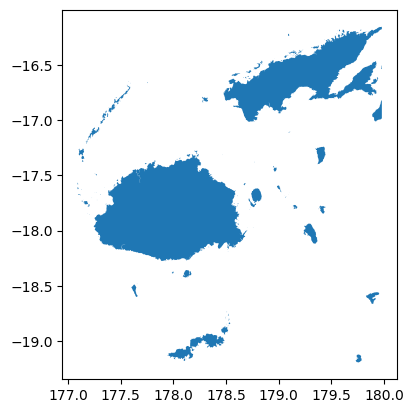

In [4]:
fiji.plot()

Setup ring buffers

<Axes: >

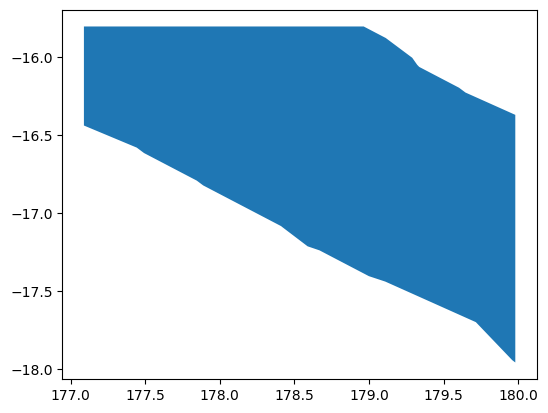

In [5]:
Yasa_64kn.plot()

<Axes: >

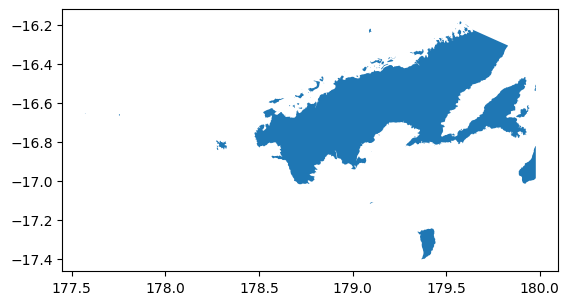

In [6]:
Yasa_fj = gpd.clip(fiji, Yasa_64kn)
Yasa_fj.plot()

In [7]:
Yasa_fj = Yasa_fj.to_crs("EPSG:32760")

In [8]:
buffer_100 = Yasa_fj.buffer(-100)
# buffer_250 = fiji.buffer(-250)
# buffer_500 = fiji.buffer(-500)
# buffer_1000 = fiji.buffer(-1000)
# buffer_2000 = fiji.buffer(-2000)
# buffer_3000 = fiji.buffer(-3000)

In [9]:
fiji = fiji.to_crs("EPSG:32760")

In [10]:
ring_buffer_100 = buffer_100.symmetric_difference(Yasa_fj, align=True)
# ring_buffer_250 = buffer_250.symmetric_difference(fiji, align=True)
# ring_buffer_500 = buffer_500.symmetric_difference(fiji, align=True)
# ring_buffer_1000 = buffer_1000.symmetric_difference(fiji, align=True)
# ring_buffer_2000 = buffer_2000.symmetric_difference(fiji, align=True)
# ring_buffer_3000 = buffer_3000.symmetric_difference(fiji, align=True)

<Axes: >

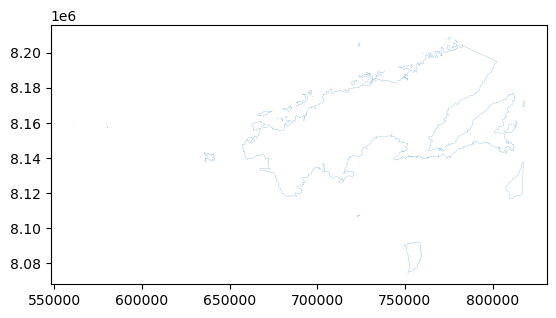

In [11]:
ring_buffer_100.plot()

In [12]:
polygon = ring_buffer_100.geometry[0]

In [13]:
# Flatten to a single Polygon
flattened_polygon = unary_union(polygon)

In [14]:
buffer = gpd.GeoDataFrame(geometry=[flattened_polygon], crs="EPSG:32760")  # Adjust CRS as needed

<Axes: >

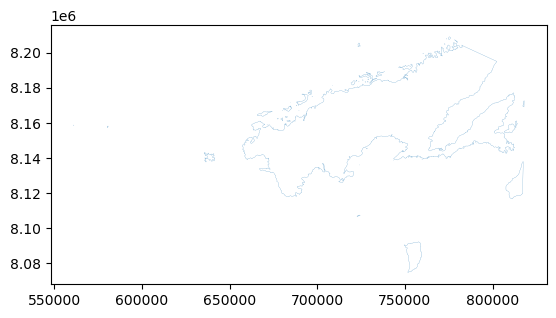

In [15]:
buffer.plot()

In [16]:
# buffer.to_file("test-buffer.geojson")

In [17]:
raster_path = "GFW/LossYear_GFW_Fiji.tif"

CRS: EPSG:4326
Bounds: BoundingBox(left=176.78846280169938, bottom=-19.371546897773065, right=181.86439331461673, top=-15.95920645951665)


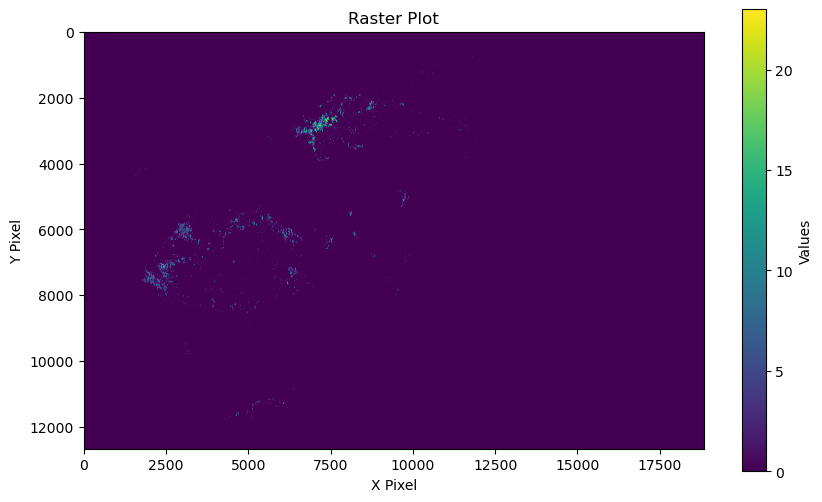

In [18]:
with rasterio.open(raster_path) as src:
    # Read the raster's first band
    data = src.read(1)  # Reads the first band (use src.read() for all bands)
    crs = src.crs
    bounds = src.bounds
    print("CRS:", crs)
    print("Bounds:", bounds)

# Plot the raster
plt.figure(figsize=(10, 6))
plt.imshow(data, cmap='viridis')  # Change cmap for different color maps
plt.colorbar(label="Values")
plt.title("Raster Plot")
plt.xlabel("X Pixel")
plt.ylabel("Y Pixel")
plt.show()

In [19]:
# The specific value you want to extract
specific_value = 15
output_raster_path = "GFW/GFW_TC_Winston_2016.tif"

# Open the input raster file
with rasterio.open(raster_path) as src:
    # Read the data for the first band (you can modify for multi-band raster)
    band = src.read(1)  # Read the first band
    
    # Ensure no-data value is valid for the raster's data type
    dtype = band.dtype
    if dtype == np.uint8:
        custom_nodata = 255  # Valid no-data value for uint8
    else:
        custom_nodata = -9999  # Default for other data types
    
    # Create a mask where the value matches the specific value
    mask = band == specific_value
    
    # Replace the non-matching values with the custom no-data value
    band[~mask] = custom_nodata  # Set all other pixels to custom no-data value
    
    # Copy the metadata from the source raster
    metadata = src.meta

    # Update the metadata to reflect that the new raster is single-band
    metadata.update(count=1, nodata=custom_nodata)
    
    # Create and write the new raster file with the filtered values
    with rasterio.open(output_raster_path, 'w', **metadata) as dst:
        dst.write(band, 1)  # Write the modified data (filtered)

print(f"New raster created: {output_raster_path}")

New raster created: GFW/GFW_TC_Winston_2016.tif


In [20]:
with rasterio.open(raster_path) as src:
    raster_data = src.read(1)  # Read the first band
    transform = src.transform  # Get the affine transform
    crs = "EPSG:4326"

In [21]:
import rasterio
import numpy as np

# Path to the input raster and the output raster
input_raster_path = "GFW/LossYear_GFW_Fiji.tif"
output_raster_path = "GFW/GFW_TC_Winston_2016.tif"

# The specific value you want to extract
specific_value = 15

# Open the input raster file
with rasterio.open(input_raster_path) as src:
    # Read the data for the first band (you can modify for multi-band raster)
    band = src.read(1)  # Read the first band
    
    # Ensure no-data value is valid for the raster's data type
    dtype = band.dtype
    if dtype == np.uint8:
        custom_nodata = 255  # Valid no-data value for uint8
    else:
        custom_nodata = -9999  # Default for other data types
    
    # Create a mask where the value matches the specific value
    mask = band == specific_value
    
    # Replace the non-matching values with the custom no-data value
    band[~mask] = custom_nodata  # Set all other pixels to custom no-data value
    
    # Copy the metadata from the source raster
    metadata = src.meta
    
    # Update the metadata to reflect that the new raster is single-band
    metadata.update(count=1, nodata=custom_nodata)

    # include crs
    crs = "EPSG:32760"
    
    # Create and write the new raster file with the filtered values
    with rasterio.open(output_raster_path, 'w', **metadata) as dst:
        dst.write(band, 1)  # Write the modified data (filtered)

print(f"New raster created: {output_raster_path}")


New raster created: GFW/GFW_TC_Winston_2016.tif


In [22]:
# Open the raster data
with rasterio.open(raster_path) as src:
    # Get the raster's data as an array
    image = src.read(1)  # Read the first band
    # include crs
    crs = "EPSG:4326"
    
    # Extract shapes from the raster
    # 'transform' will be used to convert pixel coordinates into spatial coordinates
    results = shapes(image, mask=None, transform=src.transform)

    # Create a list of geometries and associated values from the results
    geometries = []
    for geom, value in results:
        geometries.append({"geometry": shape(geom), "value": value})
# Convert the list of geometries into a GeoDataFrame
gdf = gpd.GeoDataFrame(geometries)

<Axes: >

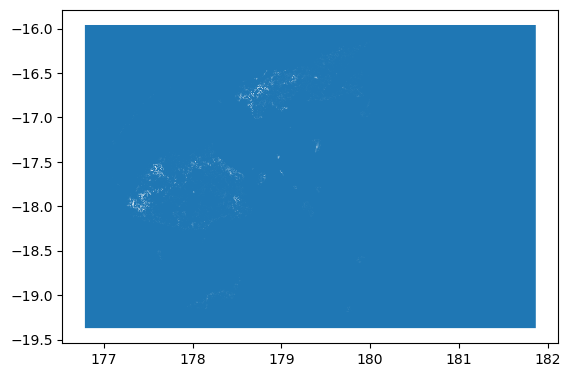

In [23]:
gdf.plot()

In [24]:
# gdf.to_crs("EPSG:32760")
if gdf.crs is None:
    gdf.set_crs("EPSG:4326", inplace=True)  # Replace 'XXXX' with the correct CRS


In [25]:
# Ensure the GeoDataFrame contains Polygon geometries
# Here, we assume that the first geometry in the GeoDataFrame is a Polygon.
polygons = gdf.geometry.tolist()

polygons = gdf[gdf.geometry.type.isin(["Polygon", "MultiPolygon"])].geometry.tolist()
multipolygon = MultiPolygon(polygons)


In [26]:
# if filter_column not in gdf.columns:
#     raise ValueError(f"Column '{filter_column}' does not exist in the GeoDataFrame.")


In [27]:
import geopandas as gpd
from shapely.geometry import MultiPolygon

# Ensure the GeoDataFrame contains valid Polygon geometries
polygons = gdf[gdf.geometry.type.isin(["Polygon", "MultiPolygon"])].geometry.tolist()

# Convert to a MultiPolygon
multipolygon = MultiPolygon(polygons)

# Create a new GeoDataFrame with the MultiPolygon
multipolygon_gdf = gpd.GeoDataFrame({'geometry': [multipolygon]})


In [28]:

# Set the CRS (ensure it matches gdf or set explicitly if missing)
if gdf.crs is None:
    gdf.set_crs("EPSG:4326", inplace=True)  # Replace with the correct CRS
multipolygon_gdf.set_crs(gdf.crs, inplace=True)

# Validate geometries
multipolygon_gdf["geometry"] = multipolygon_gdf.geometry.buffer(0)

# Specify the column and the specific value to filter
filter_column = "value"  # Column with the values
specific_value = 15  # Replace with the value you want to extract


In [29]:

# Ensure the filter column exists
if filter_column not in gdf.columns:
    raise ValueError(f"Column '{filter_column}' does not exist in the GeoDataFrame.")

# Filter the GeoDataFrame for the specific value
filtered_gdf = gdf[gdf[filter_column] == specific_value]

# Transform CRS if necessary
filtered_gdf = filtered_gdf.to_crs("EPSG:4326")

# Save the filtered GeoDataFrame to a new file
filtered_gdf.to_file("filtered_polygons.gpkg", driver="GPKG")

# Display the result
print(filtered_gdf.head())

                                               geometry  value
4417  POLYGON ((179.08806 -16.48822, 179.08806 -16.4...   15.0
4525  POLYGON ((179.06084 -16.49281, 179.06084 -16.4...   15.0
4561  POLYGON ((179.14465 -16.49388, 179.14465 -16.4...   15.0
4789  POLYGON ((179.09641 -16.50116, 179.09641 -16.5...   15.0
4850  POLYGON ((178.91289 -16.50278, 178.91289 -16.5...   15.0


In [30]:
print(filtered_gdf.crs)

EPSG:4326


In [31]:
filtered_gdf = filtered_gdf.set_crs("EPSG:4326")
filtered_gdf.to_file("test-filtered.geojson")

In [32]:
buffer = buffer.to_crs("EPSG:4326")

In [33]:
# filtered_gdf.to_file("test_filtered.geojson")

In [34]:
# filtered_gdf.to_crs("EPSG:4326")

In [35]:
intersection_exists = buffer.geometry.intersects(filtered_gdf.unary_union).any()
print("Do they intersect?", intersection_exists)

/tmp/ipykernel_1315/3829474141.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  intersection_exists = buffer.geometry.intersects(filtered_gdf.unary_union).any()


Do they intersect? True


In [36]:
clipped_gdf = gpd.clip(filtered_gdf, buffer)

<Axes: >

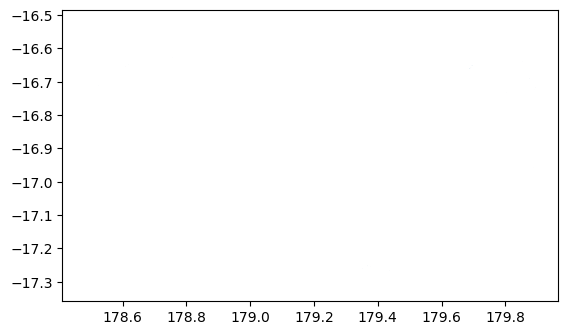

In [37]:
clipped_gdf.plot()

In [38]:
clipped_gdf.to_file("clipped.geojson")

In [40]:
clipped_gdf = clipped_gdf.to_crs("EPSG:32760")

In [42]:
area_gfw = clipped_gdf.geometry.area

In [48]:
total_area = area_gfw.sum()
print(total_area, "m2 tree cover loss") 

57634.21483873444 m2 tree cover loss
